In [1]:
import os
import sys
import time
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import class_weight
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation, Input, GlobalAveragePooling2D
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import SGD, RMSprop
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.callbacks import TensorBoard

# from google.colab import drive
# drive.mount("/content/gdrive")

Using TensorFlow backend.


In [2]:
drive_base_path = "../"
path_to_balanced_images = drive_base_path + "dataset/Balanced_Training_Input_Aug/"

In [3]:
NAME = "InceptionV3_%s" % (int(time.time()))
tensorboard = TensorBoard(log_dir='./logs/%s' % (NAME))

In [4]:
def load_sample(path_to_images, number_of_images):
    list_of_images = os.listdir(path_to_images)
    x = []
    for i, filename in enumerate(list_of_images):
        image = cv2.imread(path_to_images + filename)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        x.append(image)
        
        if i >= number_of_images:
            break
    
    x = np.array(x)
    return x       

In [5]:
path_to_images = drive_base_path + "dataset/ISIC2018_Training_Input/"
x = load_sample(path_to_images, 1000)
print(x.shape)

(1001, 450, 600, 3)


In [6]:
datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    rotation_range=30,
    zoom_range=0.2,
    fill_mode='constant',
    cval=0,
    rescale=1./255,
    validation_split=0.1,
    data_format="channels_last")

In [7]:
datagen.fit(x)

In [8]:
classes = ['mel', 'nv', 'bcc', 'akiec', 'bkl', 'df', 'vasc']
batch_size = 16
train_generator = datagen.flow_from_directory(
                    directory=path_to_balanced_images,
                    target_size=(299, 299),
                    batch_size=batch_size,
                    classes=classes,
                    shuffle=True,
                    subset='training')

validation_generator = datagen.flow_from_directory(
                    directory=path_to_balanced_images,
                    target_size=(299, 299),
                    batch_size=batch_size,
                    classes=classes,
                    shuffle=True,
                    subset='validation')

Found 29871 images belonging to 7 classes.
Found 3317 images belonging to 7 classes.


In [9]:
train_samples = train_generator.samples
valid_samples = validation_generator.samples

In [10]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

print(class_weights)

[1.06495775 0.7070896  1.08196899 1.11533866 1.07841438 1.03074534
 1.07705344]


# DEFINING THE MODEL

In [11]:
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="categorical_crossentropy", optimizer=RMSprop(lr=1e-4), metrics=["accuracy"])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [ ]:
epochs = 5
history = model.fit_generator(train_generator, 
                              steps_per_epoch=train_samples / batch_size,
                              validation_data=validation_generator,
                              validation_steps=valid_samples / batch_size,
                              epochs=epochs,
#                               class_weight=class_weights,
                              verbose=1,
                              callbacks=[tensorboard])

Epoch 1/5
1867/1866 [==============================] - 774s 415ms/step - loss: 1.2324 - acc: 0.5400 - val_loss: 1.1969 - val_acc: 0.5635
Epoch 2/5
1867/1866 [==============================] - 768s 411ms/step - loss: 1.0029 - acc: 0.6309 - val_loss: 1.1358 - val_acc: 0.5945
Epoch 3/5
1867/1866 [==============================] - 766s 410ms/step - loss: 0.9117 - acc: 0.6628 - val_loss: 1.1166 - val_acc: 0.5978
Epoch 4/5
1867/1866 [==============================] - 766s 410ms/step - loss: 0.8495 - acc: 0.6859 - val_loss: 1.1087 - val_acc: 0.6229
Epoch 5/5
1866/1866 [============================>.] - ETA: 0s - loss: 0.8008 - acc: 0.7012

In [ ]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

In [ ]:
NAME = "InceptionV3_REST_%s" % (int(time.time()))
tensorboard = TensorBoard(log_dir='./logs/%s' % (NAME))

In [ ]:
model.compile(optimizer=SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=["accuracy"])
epochs = 20
history = model.fit_generator(train_generator, 
                              steps_per_epoch=train_samples / batch_size,
                              validation_data=validation_generator,
                              validation_steps=valid_samples / batch_size,
#                               class_weight=class_weights,
                              epochs=epochs,
                              verbose=1,
                              callbacks=[tensorboard])
model.save_weights(drive_base_path + 'models/InceptionV3Net_ISIC_cnn.h5')

Epoch 1/20
1867/1866 [==============================] - 773s 414ms/step - loss: 0.9074 - acc: 0.6722 - val_loss: 0.9323 - val_acc: 0.6889
Epoch 2/20
1867/1866 [==============================] - 767s 411ms/step - loss: 0.6220 - acc: 0.7668 - val_loss: 0.9016 - val_acc: 0.6988
Epoch 3/20
1867/1866 [==============================] - 767s 411ms/step - loss: 0.5221 - acc: 0.8016 - val_loss: 0.9196 - val_acc: 0.7039
Epoch 4/20
1867/1866 [==============================] - 765s 410ms/step - loss: 0.4624 - acc: 0.8268 - val_loss: 0.9420 - val_acc: 0.7079
Epoch 5/20
1867/1866 [==============================] - 764s 409ms/step - loss: 0.4123 - acc: 0.8435 - val_loss: 0.8673 - val_acc: 0.7353
Epoch 6/20
1867/1866 [==============================] - 764s 409ms/step - loss: 0.3750 - acc: 0.8584 - val_loss: 0.9596 - val_acc: 0.7257
Epoch 7/20
1867/1866 [==============================] - 765s 410ms/step - loss: 0.3374 - acc: 0.8722 - val_loss: 0.9213 - val_acc: 0.7275
Epoch 8/20
1867/1866 [============

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1419/1866 [=====================>........] - ETA: 2:46 - loss: 0.2531 - acc: 0.9068

# ACCURACY AND LOSS PLOTS

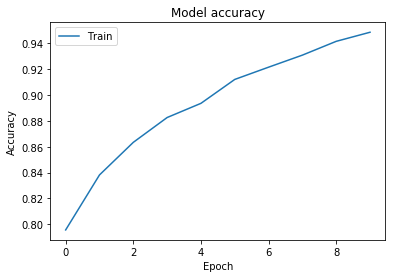

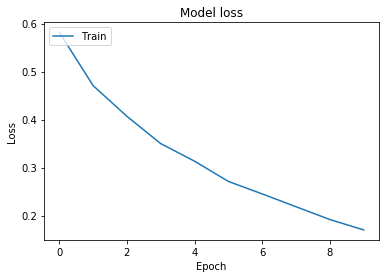

In [18]:
# Plot Training and Validation Accuracy
plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# CONFUSION MATRIX

In [ ]:
classes = ['mel', 'nv', 'bcc', 'akiec', 'bkl', 'df', 'vasc']
validation_generator = datagen.flow_from_directory(
                    directory=path_to_balanced_images,
                    target_size=(224, 224),
                    batch_size=1,
                    classes=classes,
                    shuffle=False,
                    subset='validation')

In [ ]:
filepath = drive_base_path + "models/checkpoint/VGG16_REST.14-1.38.hdf5"
model.load_weights(filepath)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

Y_pred = model.predict_generator(validation_generator, steps=valid_samples / 1)
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
class_names = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]
plot_confusion_matrix(validation_generator.classes, y_pred, classes=class_names, title='Confusion matrix')
plt.show()

# ISIC LIVE IMAGE TEST/VALIDATION DATA

In [19]:
path_to_images = drive_base_path + "dataset/ISIC2018_Task3_Test_Input/"

In [23]:
def preprocess_images(path_to_images):
    images_list = []
    filename_list = []
    
    path_to_images = path_to_images + 'test/'
    
    input_size = 299
    list_of_images = os.listdir(path_to_images)
    number = len(list_of_images)
    
    for filename in tqdm(list_of_images, total=number):
        filename_list.append(filename[:-4])
        
        image = cv2.imread(path_to_images + filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (input_size, input_size))

        arr = np.array(image)
        images_list.append(image)
        
    images_list = np.array(images_list)
    filename_list = np.array(filename_list)
    filename_list = filename_list[:, None]
    return (images_list, filename_list)

In [24]:
x_test, names = preprocess_images(path_to_images)

In [25]:
print(x_test.shape)
print(names.shape)

(1512, 299, 299, 3)
(1512, 1)


In [26]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    data_format="channels_last")

# datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     data_format="channels_last")

In [27]:
# datagen.fit(x_test)

In [28]:
test_generator = datagen.flow(
                    x_test,
                    batch_size=1,
                    shuffle=False)

In [29]:
model.load_weights(drive_base_path + 'models/InceptionV3Net_ISIC_cnn.h5')

In [30]:
predictions = model.predict_generator(test_generator, steps=len(x_test))
# classes = (predictions > 0.5).astype(np.float)
# print(classes.shape)

In [31]:
final_output = np.concatenate((names, predictions), axis=1)
final_output.shape

(1512, 8)

In [32]:
import csv

with open(drive_base_path + "output.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["image", "MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"])
    writer.writerows(final_output)